In [14]:
import glob
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from swap_strategy import create_qaoa_swap_circuit, SATMapper
from utils import load_graph_from_npy
from graph_to_ansatz import GraphAnsatzConverter
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

base_path = "graphs"

swap_strategy_results = defaultdict(list)

In [20]:
def plot_swap_counts(results, label=None, color="blue"):
    keys = list(results.keys())
    means = [np.mean(values) for values in results.values()]
    std_devs = [np.std(values) for values in results.values()]

    plt.figure(figsize=(8, 6))
    plt.plot(keys, means, label=label, marker="o", linestyle="-", color=color)
    plt.fill_between(
        keys,
        [m - s for m, s in zip(means, std_devs)],
        [m + s for m, s in zip(means, std_devs)],
        color=color,
        alpha=0.2,
    )

    plt.xlabel("Qubits")
    plt.ylabel("Swap counts")
    plt.title("Swap counts vs. qubit counts")
    plt.legend()
    plt.grid(True)

    plt.show()

In [16]:
for n in range(4, 10):
    pattern = os.path.join(base_path, f"adj_matrix_{n}_*.npy")
    file_paths = glob.glob(pattern)
    for file_path in file_paths:
        g = load_graph_from_npy(file_path)
        swap_strategy = SwapStrategy.from_line(range(len(g.nodes())))
        sm = SATMapper(timeout=10)
        remapped_graph, edge_map, min_swap_layers = sm.remap_graph_with_sat(
            graph=g, swap_strategy=swap_strategy, max_layers=1
        )
        # print("Map from old to new nodes: ", edge_map)
        # print("Min SWAP layers:", min_swap_layers)
        converter = GraphAnsatzConverter(
            g if remapped_graph is None else remapped_graph
        )
        qaoa_circ = create_qaoa_swap_circuit(
            converter.hamiltonian, swap_strategy, qaoa_layers=1
        )
        # qaoa_circ.decompose(reps=1).draw(output="mpl")
        swap_strategy_results[n].append(
            len(qaoa_circ.decompose(reps=1).get_instructions("swap"))
        )

Layers: 0, Status: True, Time: 1.3000000000928935e-05
Layers: 0, Status: False, Time: 2.5000000000829914e-05
Layers: 0, Status: False, Time: 2.800000000036107e-05
Layers: 0, Status: True, Time: 1.5999999998683734e-05
Layers: 0, Status: False, Time: 2.999999999886427e-05
Layers: 0, Status: False, Time: 2.0000000001019203e-05
Layers: 0, Status: True, Time: 1.100000000064938e-05
Layers: 0, Status: False, Time: 2.19999999995224e-05
Layers: 0, Status: True, Time: 1.3000000000928935e-05
Layers: 0, Status: False, Time: 1.9999999999242846e-05
Layers: 0, Status: False, Time: 2.19999999995224e-05
Layers: 0, Status: True, Time: 9.999999999621423e-06
Layers: 0, Status: True, Time: 1.4000000000180535e-05
Layers: 0, Status: False, Time: 1.8000000000739647e-05
Layers: 0, Status: True, Time: 1.1999999999900979e-05
Layers: 0, Status: False, Time: 1.8999999999991246e-05
Layers: 0, Status: True, Time: 1.1999999999900979e-05
Layers: 0, Status: False, Time: 1.799999999896329e-05
Layers: 0, Status: True, Ti

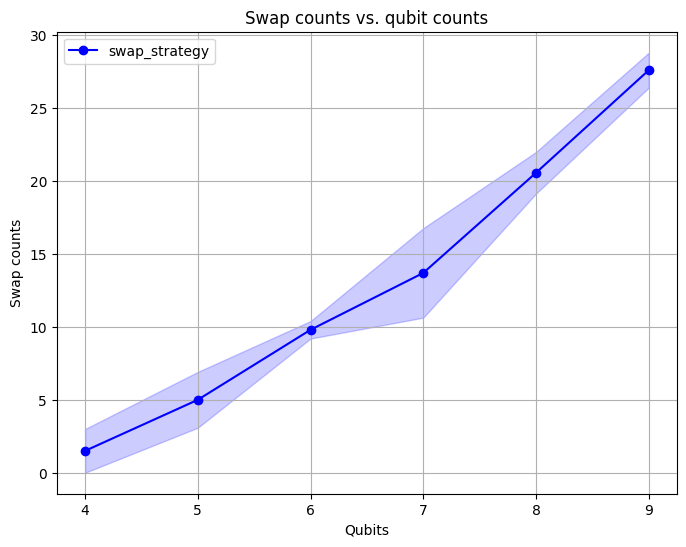

In [22]:
plot_swap_counts(swap_strategy_results, label="swap_strategy")